## Titanic - Machine Learning from Disaster

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from statistics import mean

In [2]:
data = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
gender_submission = pd.read_csv('dataset/gender_submission.csv')

### Explore the Train Data

Problem Statement: It is to build a predictive model that identifies key factors associated with survival on the Titanic. I aim to explore how variables such as age, gender, class, fare, and family connections influence the likelihood of survival. It will not only predict survival outcomes but also understand the demographic and socio-economic characteristics that were most likely to increase survival chances.

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(data.shape)
print(test.shape)

(891, 12)
(418, 11)


### Data Preprocessing

In [5]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
data.duplicated().sum()

0

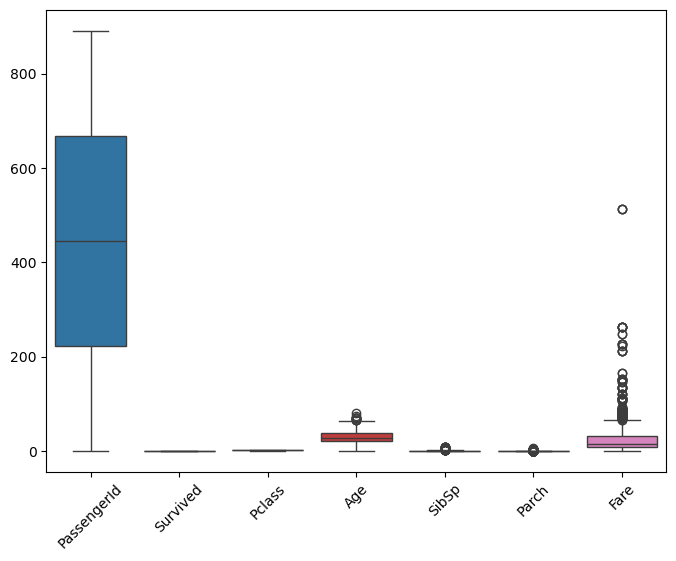

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data)
plt.xticks(rotation=45)
plt.show()

In [8]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data, data[(data[column] < lower_bound) | (data[column] > upper_bound)]

numerical_cols = data.select_dtypes(include=['number']).columns
for col in numerical_cols:
    outliers = detect_outliers_iqr(data, col)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in PassengerId: 2
Outliers in Survived: 2
Outliers in Pclass: 2
Outliers in Age: 2
Outliers in SibSp: 2
Outliers in Parch: 2
Outliers in Fare: 2


In [9]:
data['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [10]:
data['Age'] = data.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

Observation: Missing values from age are filled in with the median age within each Pclass as there are outliers. Imputing Age by Pclass is more nuanced approach compared to using a global median imputation. Fractional age is kept in case it affected to survival of parents.

In [11]:
data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [12]:
data.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

Observation: 
- Since there are high number, 687 of 891, NaNs in Cabin, and a lot of values are mixed and inconsistent, Cabin column is dropped.
- Name and Ticket columns are dropped as they are not meaningful patterns fo survival.


In [13]:
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [14]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data.isnull().sum()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8576\3631949386.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

Observation: The most common value can be a reasonable guess for two missing values.

In [15]:
data['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [16]:
data['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [17]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1  # +1 for self

# Create 'IsAlone' feature
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

In [18]:
df =  data.drop(['SibSp', 'Parch'], axis=1).copy()
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,1,0,3,male,22.0,7.2500,S,2,0
1,2,1,1,female,38.0,71.2833,C,2,0
2,3,1,3,female,26.0,7.9250,S,1,1
3,4,1,1,female,35.0,53.1000,S,2,0
4,5,0,3,male,35.0,8.0500,S,1,1


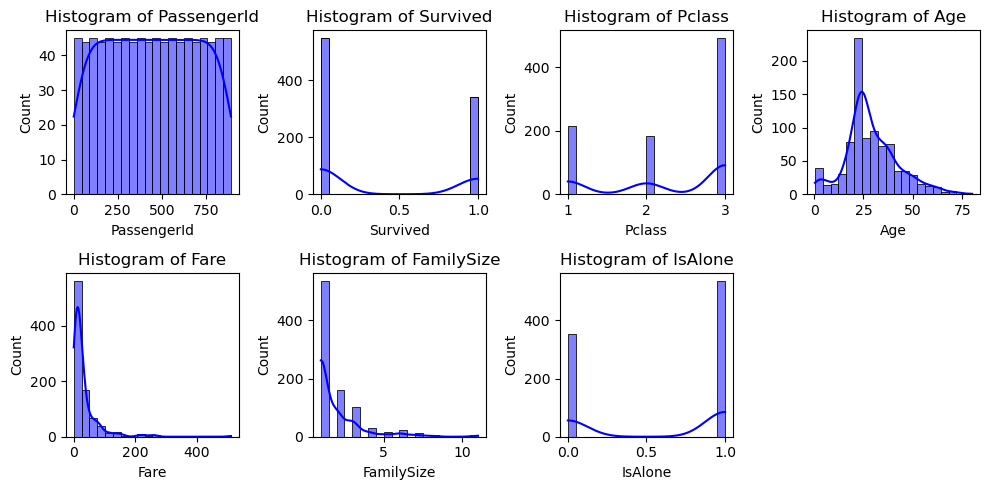

In [19]:
numerical_columns = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(10,5))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[col], kde=True, bins=20, color='blue')
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

Observation: In titanic, it seems the majority of passengers being in their 20s. Younger passengers could have had different survival chances compared to older adults. This could be useful to anlyze by looking at the survival rates for different age groups.

Most passengers had no siblings, spouse, parents, or children. If family members were prioritized for lifeboat access or rescue, the survival rate could have been different. It coulld analyze how the rate differ for solo travelers versus families.

A lot of passengers paid less than $100 and there were much more people in 3rd/lower pclass. Lower fares generally correspond to lower class tickets.

### Exploratory Data Analysis (EDA)

In [20]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.066409,0.523008,0.381594,32.204208,1.904602,0.602694
std,257.353842,0.486592,0.836071,13.244532,1.102743,0.806057,49.693429,1.613459,0.489615
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000


In [21]:
# def family_group(size):
#     if size == 1:
#         return 'Alone'
#     elif size <= 4:
#         return 'Small'
#     else:
#         return 'Large'

# df['FamilySize'] = df['FamilySize'].apply(family_group)

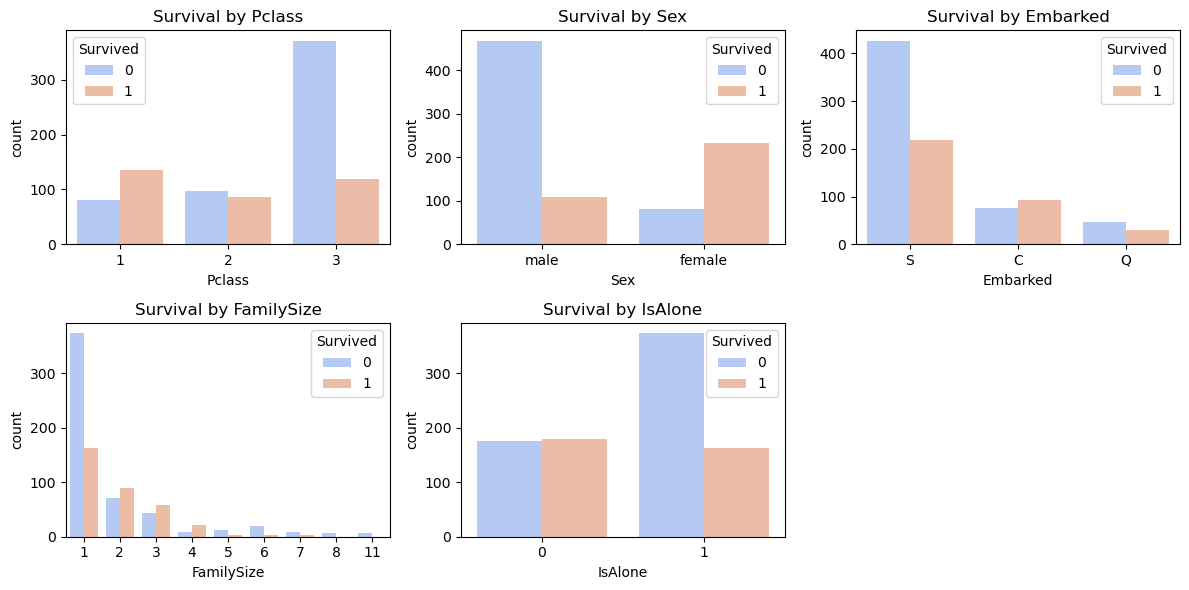

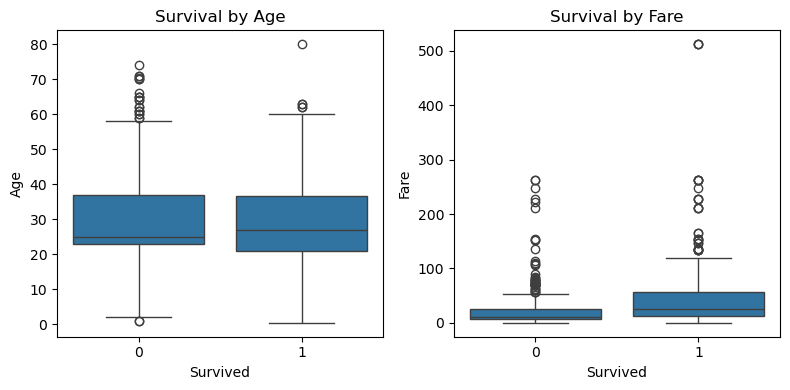

In [22]:
# List of categorical columns
categorical_columns = ['Pclass', 'Sex', 'Embarked', 'FamilySize', 'IsAlone']

# Count plots for categorical features
plt.figure(figsize=(12, 6))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=column, hue='Survived', data=df, palette='coolwarm')
    plt.title(f'Survival by {column}')
    plt.tight_layout()
plt.show()

# Box plots for numerical features like 'Age' and 'Fare'
plt.figure(figsize=(8, 4))

# Age distribution by Survived
plt.subplot(1, 2, 1)
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Survival by Age')

# Fare distribution by Survived
plt.subplot(1, 2, 2)
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Survival by Fare')

plt.tight_layout()
plt.show()


Observation:
- Pclass: Passengers in 1 class had the highest survival rate, while those in class 3 had the lowest survival rate, meaning highest number of deaths.

- Sex: The number of male who didn't survive is significantly higher than Female.

- Embarked: Most passengers embarked from Southampton, showing both survival and non-survival counts are higher.

- FamilySize, IsAlone: Passengers traveling alone had the lowest survival rate, at the same time, highest survival rate compared to those who have more than one famillysize. Large families also show lower survival rates.

- Age: Most of the older adults (over 60) had a very low survival rate.

- Fare: Passengers who paid higher fares were more likely to survive.


SURVIVAL RATE??

In [23]:
# Label encoding for Sex
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)

# # Label encoding for FamilySize
# df['FamilySize'] = df['FamilySize'].map({'Alone': 1, 'Small': 2, 'Large': 3}).astype(int)

# One-hot encoding for Embarked
df = pd.get_dummies(df, columns=['Embarked']).astype(int)

df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22,7,2,0,0,0,1
1,2,1,1,1,38,71,2,0,1,0,0
2,3,1,3,1,26,7,1,1,0,0,1
3,4,1,1,1,35,53,2,0,0,0,1
4,5,0,3,0,35,8,1,1,0,0,1


In [24]:
corr = df.select_dtypes(include=['number']).corr()
corr

,PassengerId,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.035948,0.012668,-0.040143,0.057462,-0.001205,-0.033606,0.022204
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.047266,0.257482,0.016639,-0.203367,0.168240,0.003650,-0.149683
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.408557,-0.550553,0.065997,0.135207,-0.243292,0.221009,0.074053
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.078020,0.182331,0.200988,-0.303646,0.082853,0.074115,-0.119224
Age,0.035948,-0.047266,-0.408557,-0.078020,1.000000,0.124239,-0.251898,0.165523,0.040188,-0.081692,0.016202
Fare,0.012668,0.257482,-0.550553,0.182331,0.124239,1.000000,0.217052,-0.272355,0.269165,-0.118319,-0.161341
FamilySize,-0.040143,0.016639,0.065997,0.200988,-0.251898,0.217052,1.000000,-0.690922,-0.046215,-0.058592,0.077359
IsAlone,0.057462,-0.203367,0.135207,-0.303646,0.165523,-0.272355,-0.690922,1.000000,-0.095298,0.086464,0.029074
Embarked_C,-0.001205,0.168240,-0.243292,0.082853,0.040188,0.269165,-0.046215,-0.095298,1.000000,-0.148258,-0.782742
Embarked_Q,-0.033606,0.003650,0.221009,0.074115,-0.081692,-0.118319,-0.058592,0.086464,-0.148258,1.000000,-0.499421


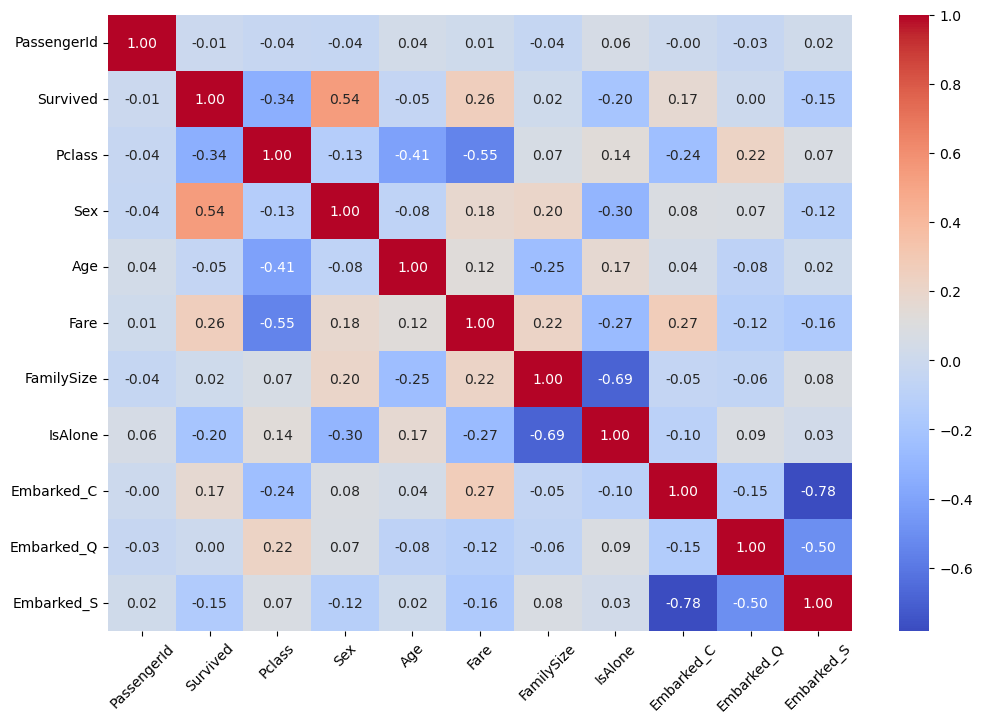

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.show()

In [26]:
survived_corr = corr['Survived'].sort_values(ascending=False)
survived_corr[1:]

Sex            0.543351
Fare           0.257482
Embarked_C     0.168240
FamilySize     0.016639
Embarked_Q     0.003650
PassengerId   -0.005007
Age           -0.047266
Embarked_S    -0.149683
IsAlone       -0.203367
Pclass        -0.338481
Name: Survived, dtype: float64

Observation:
- Sex: 0.543 correlation
    
    Strongest predictor. Female significantly increased survival chances.
- Pclass: -0.33 correlation
    
    Pclass 3 was associated with lower survival.
- IsAlone: -0.203 correlation
    
    Being alone reduced survival chances.
- Fare: 0.257 correlation
    
    Higher fare generally meant higher survival probability.

In [27]:
passenger_ids = df['PassengerId']
df.drop(columns='PassengerId', inplace=True)

Observation: PassengerId has no meaningful relationship with the target 'Survived' and there is no predictive value, so it is dropped.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Survived'),
  Text(1, 0, 'Pclass'),
  Text(2, 0, 'Sex'),
  Text(3, 0, 'Age'),
  Text(4, 0, 'Fare'),
  Text(5, 0, 'FamilySize'),
  Text(6, 0, 'IsAlone'),
  Text(7, 0, 'Embarked_C'),
  Text(8, 0, 'Embarked_Q'),
  Text(9, 0, 'Embarked_S')])

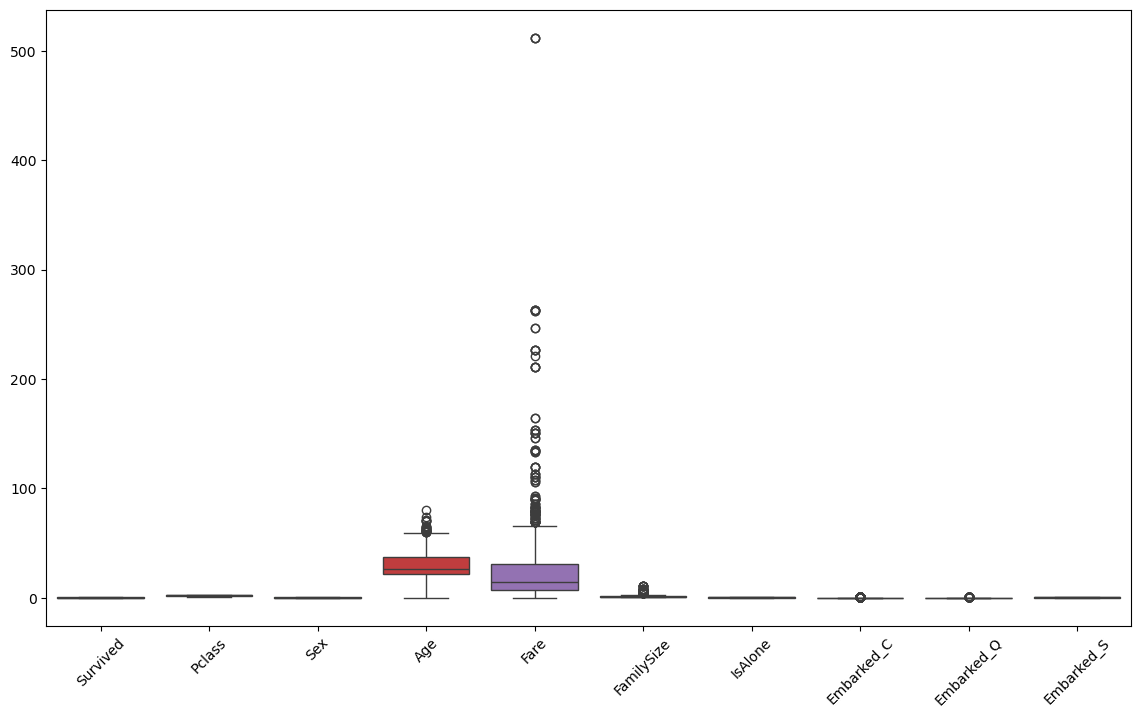

In [28]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)

Observation: Since there are outliers, using RobustScaler is a better choice.

### Model Training

In [29]:
X = df.drop('Survived', axis=1)
Y = df['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Size of training data: {X_train.shape[0]}")
print(f"Size of test data: {X_test.shape[0]}")

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

cols_to_scale = ['Age', 'Fare', 'FamilySize']
rs = RobustScaler()

X_train_scaled[cols_to_scale] = rs.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = rs.transform(X_test[cols_to_scale])

Size of training data: 712
Size of test data: 179


### Logistic Regression

In [30]:
def evaluate_model(model, X_train_scaled, X_test_scaled, Y_train, Y_test):

    model.fit(X_train_scaled, Y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Accuracy
    print(f"Train Accuracy: {accuracy_score(Y_train, y_train_pred):.2f}")
    print(f"Test Accuracy: {accuracy_score(Y_test, y_test_pred):.2f}")

    # Confusion Matrix (Train)
    print(f"\nConfusion Matrix (Train):\n {confusion_matrix(Y_train, y_train_pred)}")

    # Confusion Matrix (Test)
    print(f"\nConfusion Matrix (Test):\n {confusion_matrix(Y_test, y_test_pred)}")

    target_names = ['Not Survived', 'Survived']
    
    # Classification Report (Train)
    print("\nClassification Report (Train):")
    print(classification_report(Y_train, y_train_pred, target_names=target_names))

    # Classification Report (Test)
    print("\nClassification Report (Test):")
    print(classification_report(Y_test, y_test_pred, target_names=target_names))

    return model

lr = LogisticRegression(random_state=42, max_iter=200)
evaluate_model(lr, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.80
Test Accuracy: 0.81

Confusion Matrix (Train):
 [[386  58]
 [ 83 185]]

Confusion Matrix (Test):
 [[92 13]
 [21 53]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.82      0.87      0.85       444
    Survived       0.76      0.69      0.72       268

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.81      0.88      0.84       105
    Survived       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



LogisticRegression(max_iter=200, random_state=42)

Overall Performance:
- Accuracy: The model is generalizing well. No major overfitting is happening.

- Confusion Matrix (Test): The model predicts 'Not Survived' a bit better than 'Survived'.

- Classification Report (Test):
    - Precision for Survived (0.80): 80% of the time the model says someone survived.
    - Recall for Survived (0.72): The model only catches 72% of acutal survivors. It might be missing survivors.
    - F1-Score for Survived (0.76): Balanced view of precision and recall.

### KNN

In [31]:
knn = KNeighborsClassifier()
evaluate_model(knn, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.85
Test Accuracy: 0.82

Confusion Matrix (Train):
 [[398  46]
 [ 61 207]]

Confusion Matrix (Test):
 [[89 16]
 [16 58]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.87      0.90      0.88       444
    Survived       0.82      0.77      0.79       268

    accuracy                           0.85       712
   macro avg       0.84      0.83      0.84       712
weighted avg       0.85      0.85      0.85       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.85      0.85      0.85       105
    Survived       0.78      0.78      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



KNeighborsClassifier()

Overall Performance:
- Accuracy: The model is performing well on both the training and test datasets, but there is a slight overfitting.

- Confusion Matrix (Test): The model's performance on the 'Survived' class is slightly lower compared to 'Not Survived'.

- Classification Report (Test):
    - Precision and Recall for Survived (0.78): The model is correctly identifying survivors but could still be improved. Also, because the recall for 'Survived' is lower on the test data compared to the training data, indicating possible issues with generalization.

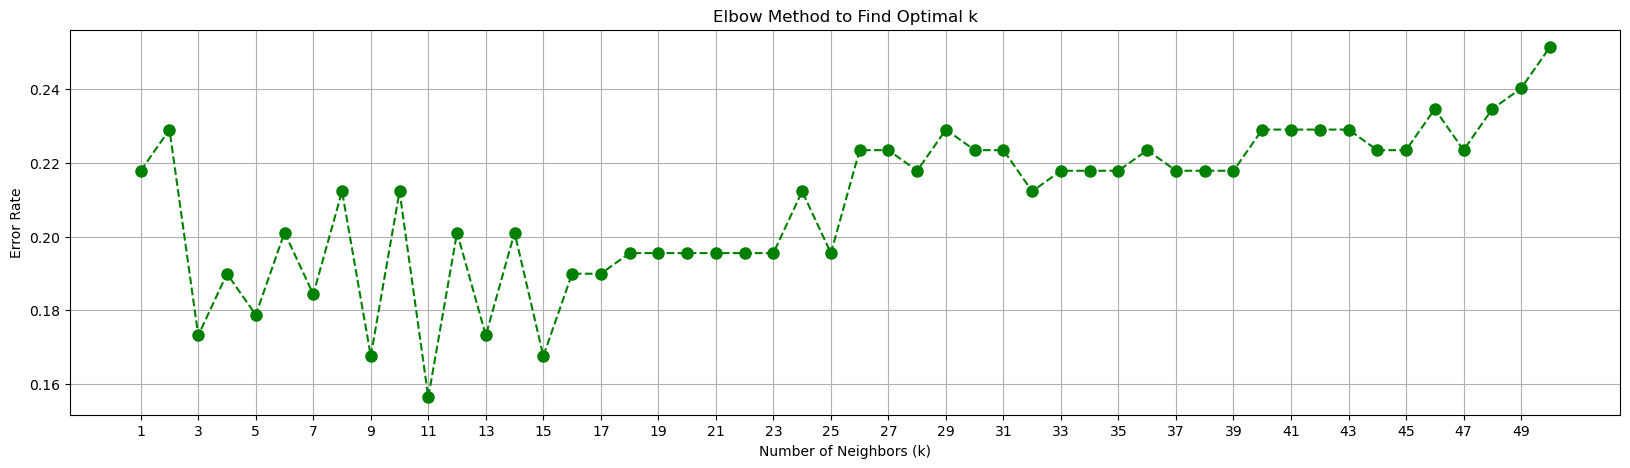

In [32]:
error_rates =[]
k_values = range(1, 51)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, Y_train)  # train the model
    y_knn_pred = knn.predict(X_test_scaled)  # predict on test set
    error = 1 - accuracy_score(Y_test, y_knn_pred)  # calculate error rate
    error_rates.append(error)

# plot the elbow curve to find the optimal value of k
plt.figure(figsize=(20, 5))
plt.plot(k_values, error_rates, marker='o', linestyle='dashed', markersize=8, color='green')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Elbow Method to Find Optimal k')
plt.xticks(np.arange(1, 51, step=2))
plt.grid(True)
plt.show()

Observation: The error rate significantly decreased when k=11. After that, we don't see any further dip.

In [33]:
knn_11 = KNeighborsClassifier(n_neighbors=11)
evaluate_model(knn_11, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.82
Test Accuracy: 0.84

Confusion Matrix (Train):
 [[396  48]
 [ 83 185]]

Confusion Matrix (Test):
 [[90 15]
 [13 61]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.83      0.89      0.86       444
    Survived       0.79      0.69      0.74       268

    accuracy                           0.82       712
   macro avg       0.81      0.79      0.80       712
weighted avg       0.81      0.82      0.81       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.87      0.86      0.87       105
    Survived       0.80      0.82      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



KNeighborsClassifier(n_neighbors=11)

Overall Performance:
- Accuracy: The test accuracy has improved from 82% to 84%, and the training accuracy has decreased from 85% to 82%. 

- The reduction in training accuracy might be a sign that the model is not fitting less to noise and is focusing more on general patterns. 

- The improved test accuracy means the model is more likely to perform well in real-world situations where it encouters new data.

### SMOTE on KNN

In [34]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

evaluate_model(knn_11, X_train_resampled, X_test_scaled, Y_train_resampled, Y_test)

Train Accuracy: 0.82
Test Accuracy: 0.82

Confusion Matrix (Train):
 [[363  81]
 [ 76 368]]

Confusion Matrix (Test):
 [[81 24]
 [ 8 66]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.83      0.82      0.82       444
    Survived       0.82      0.83      0.82       444

    accuracy                           0.82       888
   macro avg       0.82      0.82      0.82       888
weighted avg       0.82      0.82      0.82       888


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.91      0.77      0.84       105
    Survived       0.73      0.89      0.80        74

    accuracy                           0.82       179
   macro avg       0.82      0.83      0.82       179
weighted avg       0.84      0.82      0.82       179



KNeighborsClassifier(n_neighbors=11)

Overall Performance:
- After applying SMOTE, the test accuracy dropped slightly from 84% to 82%, but the train accuracy remained the same at 82%. This suggests that SMOTE didn't improve the model's performance on the test data.

- The fact that train accuracy remained the same suggests that the model is still fitting well to the training data, but the model might have become too focused on minority class due to SMOTE, indicating didn't help improve generalization performance.

### Decision Tree

In [35]:
dt = DecisionTreeClassifier(random_state=42)
evaluate_model(dt, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.96
Test Accuracy: 0.80

Confusion Matrix (Train):
 [[442   2]
 [ 24 244]]

Confusion Matrix (Test):
 [[89 16]
 [19 55]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.95      1.00      0.97       444
    Survived       0.99      0.91      0.95       268

    accuracy                           0.96       712
   macro avg       0.97      0.95      0.96       712
weighted avg       0.96      0.96      0.96       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.82      0.85      0.84       105
    Survived       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



DecisionTreeClassifier(random_state=42)

Overall Performance:
- Accuracy: The train accuracy is very high compared to the test accuracy with 16% of gap. It is a clear sign of overfitting. The model has likely memorized data instead of generalizing to new/unseen data.

- Confusion Matrix (Test): The model is better at predicting 'Not Survived'. It struggles more identifying actual survivors. There is a slight imbalance in performance between classes.

- Classification Report (Test):
    - Precision and Recall for Survived: The model predicted 23% survivors that were actually not and missed about 26% of real survivors.

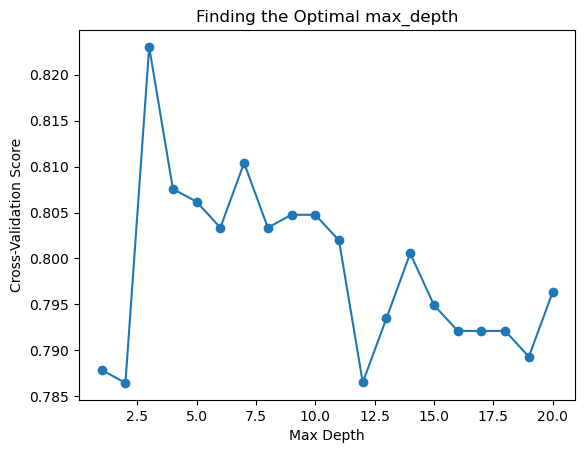

Best max_depth: 3


In [36]:
scores = []
depths = range(1, 21)
for d in depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    score = cross_val_score(dt, X_train_scaled, Y_train, cv=5).mean()
    scores.append(score)

plt.plot(depths, scores, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validation Score")
plt.title("Finding the Optimal max_depth")
plt.show()

best_depth = depths[np.argmax(scores)]
print(f"Best max_depth: {best_depth}")

In [37]:
dt_3 = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=best_depth)
evaluate_model(dt_3, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.83
Test Accuracy: 0.80

Confusion Matrix (Train):
 [[400  44]
 [ 75 193]]

Confusion Matrix (Test):
 [[92 13]
 [23 51]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.84      0.90      0.87       444
    Survived       0.81      0.72      0.76       268

    accuracy                           0.83       712
   macro avg       0.83      0.81      0.82       712
weighted avg       0.83      0.83      0.83       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.80      0.88      0.84       105
    Survived       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

Overall Performance:
- Accuracy: 
    - There is a significant reduction compared to 96%, but this is expected as the model is now more constrained and generalizing better. 
    - The test performance is very close to the training performance, showing the model is less overfitting and better balanced for future predictions.

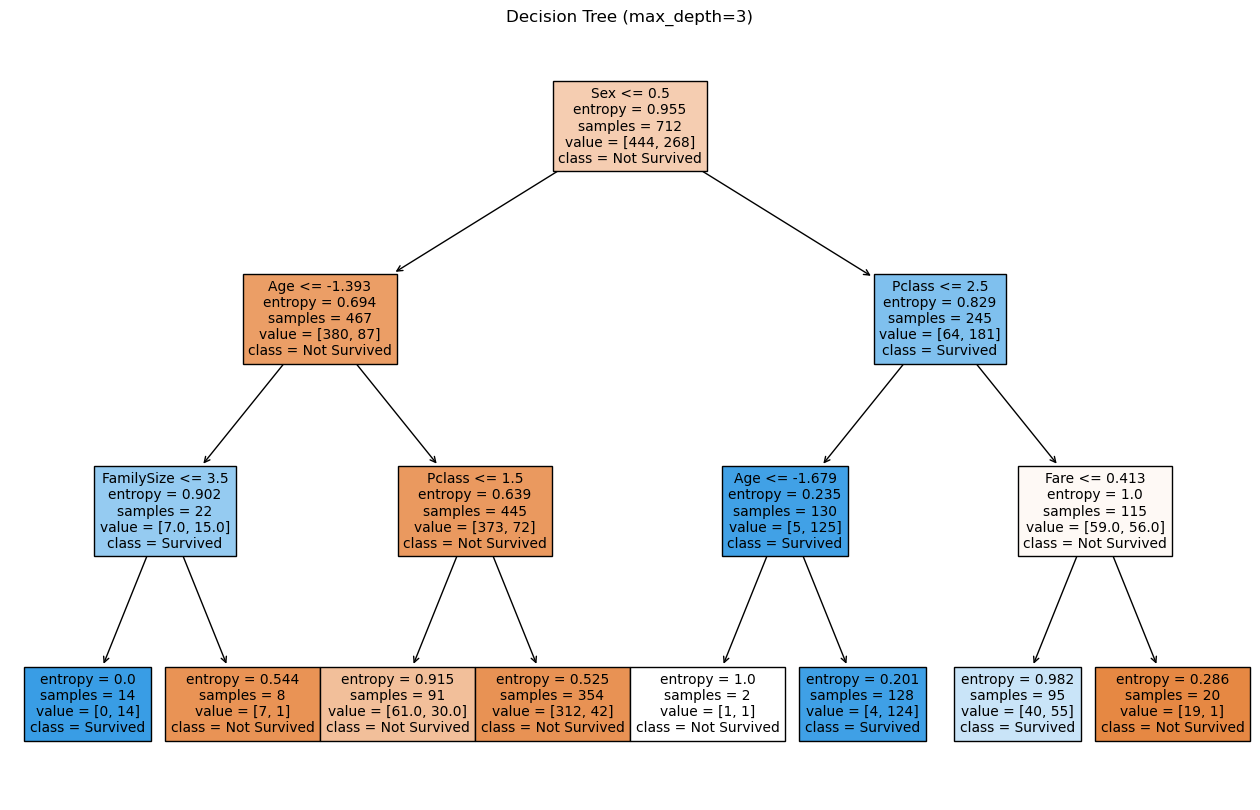

In [38]:
plt.figure(figsize=(16, 10))
plot_tree(dt_3, feature_names=X_train_scaled.columns, class_names=["Not Survived", "Survived"], filled=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()

In [39]:
# What you can try next:
# Prune the tree more: Reduce max_depth further or tune min_samples_split, min_samples_leaf.

# Try Cross-Validation to confirm general performance.

# from sklearn.model_selection import cross_val_score
# from sklearn.tree import DecisionTreeClassifier

# # Create model with limited depth
# dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# # Run 5-fold cross-validation on training data
# cv_scores = cross_val_score(dt_model, X_train_scaled, Y_train, cv=5, scoring='accuracy')

# # Results
# print(f"Cross-Validation Scores: {cv_scores}")
# print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")


### Random Forest

In [40]:
rf = RandomForestClassifier(random_state=42)
evaluate_model(rf, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.96
Test Accuracy: 0.82

Confusion Matrix (Train):
 [[438   6]
 [ 20 248]]

Confusion Matrix (Test):
 [[92 13]
 [19 55]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.96      0.99      0.97       444
    Survived       0.98      0.93      0.95       268

    accuracy                           0.96       712
   macro avg       0.97      0.96      0.96       712
weighted avg       0.96      0.96      0.96       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.83      0.88      0.85       105
    Survived       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



RandomForestClassifier(random_state=42)

Overall Performance:
- Accuracy: The train accuracy is very high compared to the test accuracy with 14% of gap. It is a clear sign of overfitting. The model has likely memorized data instead of generalizing to new/unseen data.

- Confusion Matrix (Test): There are some misclassifications, especially for 'Survived'.

- Classification Report (Test): Precision and Recall for 'Survived' are lower on the test set compared to the train set, showing that the model misses more survivors in the test set.

In [41]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train_scaled, Y_train)

print(f"Best Parameteres: {gs.best_params_}")
print(f"Best Cross-Validation Score: {gs.best_score_:.2f}")

best_rf = gs.best_estimator_
test_accuracy = best_rf.score(X_test_scaled, Y_test)
print(f"Test Accuracy with Tuned Model:  {test_accuracy:.2f}")

Best Parameteres: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Best Cross-Validation Score: 0.83
Test Accuracy with Tuned Model:  0.80


In [42]:
best_rf = RandomForestClassifier(
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=150,
    random_state=42
)

evaluate_model(best_rf, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.85
Test Accuracy: 0.80

Confusion Matrix (Train):
 [[421  23]
 [ 84 184]]

Confusion Matrix (Test):
 [[93 12]
 [23 51]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.83      0.95      0.89       444
    Survived       0.89      0.69      0.77       268

    accuracy                           0.85       712
   macro avg       0.86      0.82      0.83       712
weighted avg       0.85      0.85      0.84       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.80      0.89      0.84       105
    Survived       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=150,
                       random_state=42)

Overall Performance:
- The gap between train and test accuracy is now much smaller, reduced overfitting.
- The model generalizes better, evem though test accuracy dropped slightly.
- Although the test accuracy dropped, it became for more reliable and robust.

### Feature Importance

      Feature  Gini Importance
1         Sex         0.488825
0      Pclass         0.144440
3        Fare         0.131970
2         Age         0.114711
4  FamilySize         0.074540
8  Embarked_S         0.015867
5     IsAlone         0.012682
6  Embarked_C         0.012501
7  Embarked_Q         0.004465


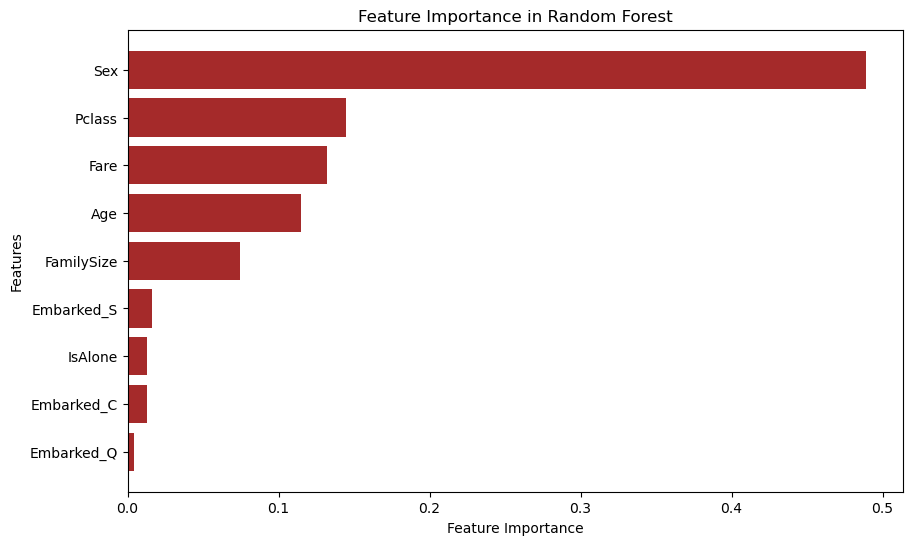

In [43]:
importances = best_rf.feature_importances_

# Sort the feature importances in the descending order of Gini importance
feature_names = X_train_scaled.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='brown')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis() # descending order
plt.show()

Observation:
- Sex (0.489): Most important by far. The survival rate is highly gender-dependent.
- Pclass (0.144): Socioeconomic status matters when 1st class had higher survival.
- IsAlone (0.013): Slight influence on survival. Being alone might affect survival, but weaker than FamilySize.

### XGBoost

In [44]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model(xgb, X_train_scaled, X_test_scaled, Y_train, Y_test)

C:\Users\dbwjd\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:33:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.95
Test Accuracy: 0.80

Confusion Matrix (Train):
 [[438   6]
 [ 27 241]]

Confusion Matrix (Test):
 [[88 17]
 [19 55]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.94      0.99      0.96       444
    Survived       0.98      0.90      0.94       268

    accuracy                           0.95       712
   macro avg       0.96      0.94      0.95       712
weighted avg       0.95      0.95      0.95       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.82      0.84      0.83       105
    Survived       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Overall Performance:
- Accuracy: The training accuracy is high 95% while the test accuracy is lower 80%, indicating overfitting.

- Confusion Matrix (Test): The model has decent balance but can be improved by tuning.

- Classification Report (Test): Precision and Recall for 'Survived' fairly balanced but there is a drop in recall so it misses some survivors.

In [45]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_s = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_s.fit(X_train_scaled, Y_train)

print("Best Parameters:", grid_s.best_params_)
print(f"Best Cross-Validation Score: {grid_s.best_score_:.2f}")

best_xgb = grid_s.best_estimator_
test_accuracy = best_xgb.score(X_test_scaled, Y_test)
print(f"Test Accuracy with Tuned Model: {test_accuracy:.2f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\dbwjd\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:34:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Score: 0.84
Test Accuracy with Tuned Model: 0.84


In [46]:
best_xgb = XGBClassifier(
    max_depth=3,
    colsample_bytree=1.0,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

evaluate_model(best_xgb, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.88
Test Accuracy: 0.84

Confusion Matrix (Train):
 [[423  21]
 [ 61 207]]

Confusion Matrix (Test):
 [[95 10]
 [19 55]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.87      0.95      0.91       444
    Survived       0.91      0.77      0.83       268

    accuracy                           0.88       712
   macro avg       0.89      0.86      0.87       712
weighted avg       0.89      0.88      0.88       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.83      0.90      0.87       105
    Survived       0.85      0.74      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

Overall Performance:
- Accuracy: The test accuracy has increased from 80% to 84%, indicating the tuned XGBoost model generalizae better to unseen data. The decrease from training accuracy indicates that the model is no longer overfitting the training data.

      Feature  Gini Importance
1         Sex         0.473704
0      Pclass         0.199210
8  Embarked_S         0.084761
4  FamilySize         0.063477
2         Age         0.052643
3        Fare         0.047207
6  Embarked_C         0.046735
7  Embarked_Q         0.032263
5     IsAlone         0.000000


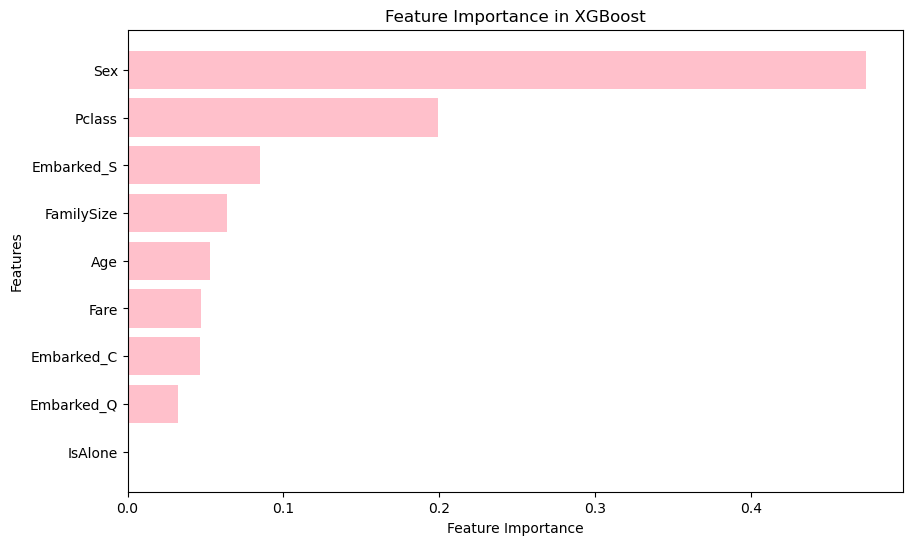

In [47]:
importances = best_xgb.feature_importances_

feature_names = X_train_scaled.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='pink')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost")
plt.gca().invert_yaxis() # descending order
plt.show()

Observation:
- Sex (0.47): Gender had strong impact on survival. Same as Random Forest result.
- Pclass (0.20): Pclass mattered.

Similar outputs from Random Forest feature importance.

### SVM

In [48]:
kernels = ['linear', 'poly', 'rbf']
models = {}

for kernel in kernels:
    print(f"Evaluating SVM with kernel: {kernel}")
    svm = SVC(kernel=kernel, probability=True, random_state=42)

    models[f"SVM({kernel})"] = evaluate_model(svm, X_train_scaled, X_test_scaled, Y_train, Y_test)

Evaluating SVM with kernel: linear
Train Accuracy: 0.80
Test Accuracy: 0.78

Confusion Matrix (Train):
 [[389  55]
 [ 87 181]]

Confusion Matrix (Test):
 [[89 16]
 [23 51]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.82      0.88      0.85       444
    Survived       0.77      0.68      0.72       268

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.79      0.85      0.82       105
    Survived       0.76      0.69      0.72        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Evaluating SVM with kernel: poly
Train Accuracy: 0.82
Test Accuracy: 0.81

Confusion Matrix (Train):
 [[396  4

Overall Performance:
- linear: The model is simple but a bit underfits.
- poly: The model has the best test accuracy and has a good balance between precision and recall.
- rbf: The model is a strong performer, slightly better generalization than linear but overfitting more than poly.

In [55]:
param_dist = {
    'C': np.logspace(-2, 2, 5),
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'kernel': ['poly']
}

svm_poly = SVC(probability=True, random_state=42)

rs = RandomizedSearchCV(estimator=svm_poly, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
rs.fit(X_train_scaled, Y_train)

print("Best Parameters:", rs.best_params_)
print(f"Best Cross-Validation Score: {rs.best_score_:.2f}")

best_svm = rs.best_estimator_
test_acc = best_svm.score(X_test_scaled, Y_test)
print(f"Test Accuracy with Tuned SVM: {test_acc:.2f}")

C:\Users\dbwjd\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 1.0}
Best Cross-Validation Score: 0.82
Test Accuracy with Tuned SVM: 0.81


In [49]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

svm_rbf = SVC(probability=True, random_state=42)

grid = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, Y_train)

print("Best Parameters:", grid.best_params_)
print(f"Best Cross-Validation Score: {grid.best_score_:.2f}")

best_svm = grid.best_estimator_
test_acc = best_svm.score(X_test_scaled, Y_test)
print(f"Test Accuracy with Tuned SVM: {test_acc:.2f}")

Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.82
Test Accuracy with Tuned SVM: 0.80


In [56]:
best_svm_poly = SVC(kernel='poly', gamma='auto', degree=3, C=1.0)

best_svm_poly.fit(X_train_scaled, Y_train)

evaluate_model(best_svm_poly, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.84
Test Accuracy: 0.81

Confusion Matrix (Train):
 [[401  43]
 [ 73 195]]

Confusion Matrix (Test):
 [[92 13]
 [21 53]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.85      0.90      0.87       444
    Survived       0.82      0.73      0.77       268

    accuracy                           0.84       712
   macro avg       0.83      0.82      0.82       712
weighted avg       0.84      0.84      0.83       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.81      0.88      0.84       105
    Survived       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



SVC(gamma='auto', kernel='poly')

In [57]:
best_svm_rbf = SVC(C=1, gamma=0.1, kernel='rbf')

best_svm_rbf.fit(X_train_scaled, Y_train)
evaluate_model(best_svm_rbf, X_train_scaled, X_test_scaled, Y_train, Y_test)

Train Accuracy: 0.83
Test Accuracy: 0.80

Confusion Matrix (Train):
 [[394  50]
 [ 72 196]]

Confusion Matrix (Test):
 [[91 14]
 [21 53]]

Classification Report (Train):
              precision    recall  f1-score   support

Not Survived       0.85      0.89      0.87       444
    Survived       0.80      0.73      0.76       268

    accuracy                           0.83       712
   macro avg       0.82      0.81      0.81       712
weighted avg       0.83      0.83      0.83       712


Classification Report (Test):
              precision    recall  f1-score   support

Not Survived       0.81      0.87      0.84       105
    Survived       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



SVC(C=1, gamma=0.1)

Observation:

- After tuning both rbf and poly, RBF has no change on accuracies, and Poly had an increase on training data. Tuning didn't improve performance, suggesting the initial model's parameters ere already well-suited for the task.

- Test accuracy is the most important metric for generalization so poly's test accuracy is 1% higher than the RBF, suggesting the Polynomial kernel might be performing better.

### CV SCORE

### ROC-AUC Curve

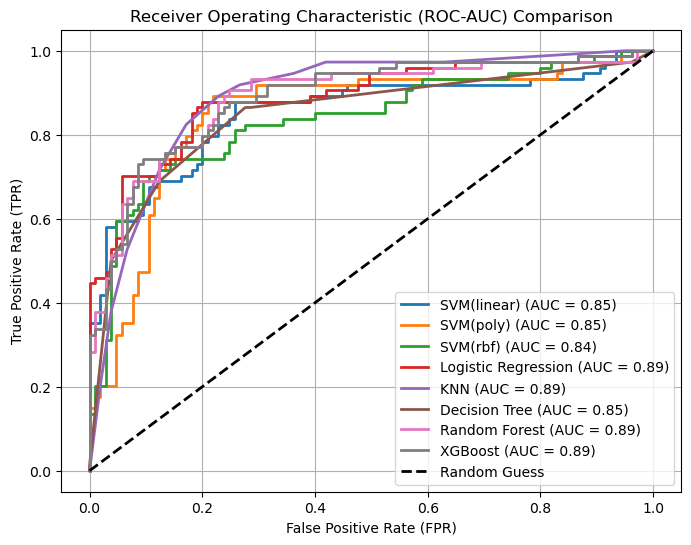

In [59]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_train_scaled, Y_test, label):

    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label = f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(8,6))

models.update({
    "Logistic Regression": lr,
    "KNN": knn_11,
    "Decision Tree": dt_3,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
})

for label, model in models.items():
    plot_roc_curve(model, X_test_scaled, Y_test, label)

# Random guess line
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC-AUC) Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Evaluate on Train Data

### Test Data